In [18]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
train = pd.read_csv("../input/train.csv")
train = train[["file_name", "category_id"]]
#train.head()

test = pd.read_csv('../input/test.csv')
test = test[['file_name']]

PATH = Path('../input')
path_test = PATH/"test_images"
path_train = PATH/"train_images"
#PATH = "../input/"

In [21]:
train_sub = train[:10000]
test_sub = test[:1000]
#print(train_sub.head())
#print(test_sub.head())

In [22]:
datatest = ImageList.from_df(test, path=path_test, cols=0)
datatest_sub = ImageList.from_df(test_sub, path=path_test, cols=0)

In [42]:
#tfms = get_transforms(do_flip=False)
#data = ImageDataBunch.from_df(path_train, train, ds_tfms=tfms, size=500)
#PATH = '../input/'
data = (ImageList.from_df(train, path=path_train, cols=0)
        .split_by_rand_pct(0.2, seed=47)
        .label_from_df(cols=1)
        .transform(get_transforms(), size = 128)
        #.transform(get_transforms(xtra_tfms=[pad(mode='reflection')]), size = 128)
        .add_test(datatest).databunch(bs=32)
        .normalize(imagenet_stats))

In [24]:
#data.show_batch(rows=3, figsize=(7,6))
#data.classes

In [43]:
learn = cnn_learner(data, models.resnet50, metrics = accuracy, model_dir="/tmp/model/")
#learn = cnn_learner(data, models.resnet34, metrics= accuracy, model_dir="/tmp/model/")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


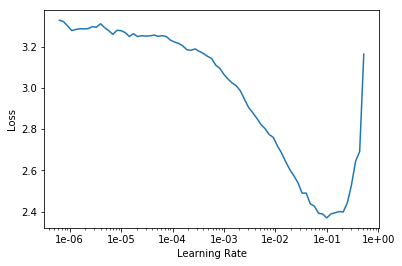

In [44]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.170948,55.233326,0.680500,03:53
1,1.043972,2.066208,0.712500,03:54


In [28]:
learn.save("fit_1")

In [29]:
#interp = ClassificationInterpretation.from_learner(learn)
#losses,idxs = interp.top_losses()
#interp.plot_top_losses(9, figsize=(15,11))
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=2)[:5]

In [30]:
#pred, y = learn.get_preds()
#f1_score = f1_score(y, np.argmax(pred.numpy(), 1), average="macro"); f1_score

In [31]:
%%time
#pred_t, _ = learn.TTA(ds_type=DatasetType.Test)
pred_t, _ = learn.get_preds(ds_type=DatasetType.Test)


CPU times: user 1.12 s, sys: 268 ms, total: 1.39 s
Wall time: 20.1 s


In [47]:
results = torch.topk(pred_t, 1)

predictions = []

for i in results[1].numpy():
    for j in i:
        predictions.append(data.classes[j])


In [48]:
import os

subm = pd.read_csv('../input/sample_submission.csv')
orig_ids = list(subm['Id'])
test_ids = [os.path.basename(f)[:-4] for f in learn.data.test_ds.items]

#orig_ids = list(set(orig_ids).intersection(test_ids))

def create_submission(orig_ids, test_ids, preds):
    preds_dict = dict((k, v) for k, v in zip(test_ids, preds))
    pred_cor = [preds_dict[id] for id in orig_ids]
    df = pd.DataFrame({'id':orig_ids,'Predicted':pred_cor})
    df.to_csv('submission.csv', header=True, index=False)
    return df


In [49]:
sub = create_submission(orig_ids, test_ids, predictions)
#sub.head()

,id,Predicted
0,cc4a6c08-2bf6-11e9-bcad-06f10d5896c4,0
1,e0845e47-2bf6-11e9-bcad-06f10d5896c4,0
2,eda12c46-2bf6-11e9-bcad-06f10d5896c4,0
3,d49ba421-2bf6-11e9-bcad-06f10d5896c4,0
4,dcee3529-2bf6-11e9-bcad-06f10d5896c4,0
